# Exploring PUBG Data for GA Data Science Final Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import bokeh as bk
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.manifold import TSNE
from scipy.misc.pilutil import imread
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import Normalize
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jacek\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Initial Hypothesis: An active playstyle in cities will lead to more wins in close quarter city combat


In [2]:
direc1 = 'C:/Users/Jacek/Documents/GA/PUGB/Deaths\\'
direc2 = 'C:/Users/Jacek/Documents/GA/PUGB/Aggregate\\'
pics = 'C:/Users/Jacek/Documents/GA/PUGB\\'

In [3]:
deaths = pd.concat([pd.read_csv(direc1 + 'kill_match_stats_final_0.csv'),
                    pd.read_csv(direc1 + 'kill_match_stats_final_1.csv'),
                    pd.read_csv(direc1 + 'kill_match_stats_final_2.csv'),
                    pd.read_csv(direc1 + 'kill_match_stats_final_3.csv')])
                   
'''             
                    ,
                    pd.read_csv(direc1 + 'kill_match_stats_final_4.csv')])
                    ,
                    pd.read_csv(direc2 + 'agg_match_stats_4.csv')])
''';

In [5]:
#z = pd.read_csv(direc2 + 'agg_match_stats_2.csv')

In [6]:
deaths['victim_placement'].nunique()

100

In [314]:
deaths.shape

(53729620, 12)

In [7]:
aggs = pd.concat([pd.read_csv(direc2 + 'agg_match_stats_0.csv'), 
                  pd.read_csv(direc2 + 'agg_match_stats_1.csv'), 
                  pd.read_csv(direc2 + 'agg_match_stats_2.csv'),
                  pd.read_csv(direc2 + 'agg_match_stats_3.csv')])

In [313]:
aggs.shape

(55375746, 15)

In [8]:
col_ref = pd.DataFrame([deaths.columns,aggs.columns])
col_ref.T

0                    1
0           killed_by                 date
1         killer_name            game_size
2    killer_placement             match_id
3   killer_position_x           match_mode
4   killer_position_y           party_size
5                 map       player_assists
6            match_id          player_dbno
7                time     player_dist_ride
8         victim_name     player_dist_walk
9    victim_placement           player_dmg
10  victim_position_x         player_kills
11  victim_position_y          player_name
12               None  player_survive_time
13               None              team_id
14               None       team_placement

In [9]:
#Count of unique players in aggs
uniques = pd.DataFrame([aggs['player_name'].nunique(),aggs['match_id'].nunique()],columns=['Uniques'],index=['Players','Matches'])
uniques

Uniques
Players  7240218
Matches   599970

In [18]:
#For simplicity's sake, let's reduce our analysi to only single player matches
#we will do this by getting only the match_ids for party_size == 1
uniques_SP = pd.DataFrame(aggs['match_id'][aggs['party_size'] ==1].unique(),columns=['match_id'])

#use below code for only specific columns (but you'll have to do a multi join!)
#uniques_SP = pd.DataFrame(aggs.loc[:, aggs.columns != ('team_id','match_mode',)][aggs['party_size'] ==1].unique(),columns=['match_id'])

uniques_SP['SP'] = 1
uniques_SP.head(2)

match_id  SP
0  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   1
1  2U4GBNA0YmnMiL8FxzK-xRalmDs8__VvvNzmntjlIzBi0D...   1

In [19]:
#Let's join these data with all the deaths data from the SP matches
joined_SP = pd.merge(deaths,uniques_SP,on='match_id',how='inner')
col_ref2 = pd.DataFrame([joined_SP.columns])

In [20]:
pd.DataFrame(joined_SP.head(1)).T

0
killed_by                                                        P92
killer_name                                                   Adlerx
killer_placement                                                  51
killer_position_x                                             391919
killer_position_y                                             235406
map                                                          ERANGEL
match_id           2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...
time                                                             425
victim_name                                                 Sventy21
victim_placement                                                  59
victim_position_x                                             392290
victim_position_y                                             235706
SP                                                                 1

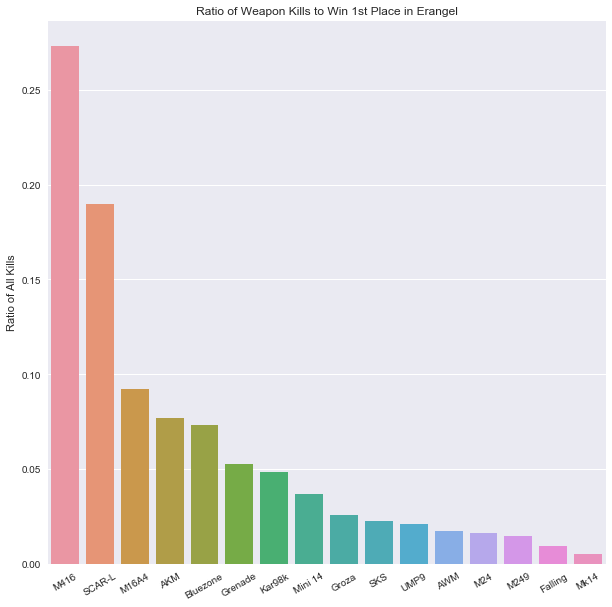

weap  ratio_kills
deadly_rank                       
1.0              M416     0.272758
2.0            SCAR-L     0.189758
3.0             M16A4     0.092420
4.0               AKM     0.077102
5.0          Bluezone     0.073396
6.0           Grenade     0.052646
7.0            Kar98k     0.048504
8.0           Mini 14     0.037009
9.0             Groza     0.025775
10.0              SKS     0.022797
11.0             UMP9     0.020886
12.0              AWM     0.017500
13.0              M24     0.016491
14.0             M249     0.014803
15.0          Falling     0.009400
17.0             Mk14     0.005171
16.0              AUG     0.002852

In [22]:
#Let's look at which weapon was the deadliest for a single player 1st place shootout in the ERANGEL map
last_death_SP = pd.DataFrame(joined_SP['killed_by'][(joined_SP['victim_placement'] == 2) & (joined_SP['map'] == 'ERANGEL')].value_counts())
pd.DataFrame(last_death_SP)

#And then add the rank of the deadliest weapon
last_death_SP['deadly_rank'] = joined_SP['killed_by'][(joined_SP['victim_placement'] == 2)].value_counts().rank(ascending=False)
last_death_SP['weap'] = last_death_SP.index
last_death_SP = last_death_SP.reset_index()
last_death_SP = last_death_SP.loc[:, last_death_SP.columns != ('index')]
last_death_SP = last_death_SP.rename(index=str, columns={"killed_by": '#_kills'})
total_kills = last_death_SP['#_kills'].sum()
last_death_SP['ratio_kills'] = last_death_SP['#_kills']/total_kills
wep_rank = last_death_SP.loc[:, last_death_SP.columns != ('#_kills')]

#Here are the weapons that had a > 1% ratio of kills for a first place win
wep_rank[wep_rank['ratio_kills'] >= 0.01]
#then, lets make a nice graph using bokeh/seaborn to show off what we've found
sns.set(style='darkgrid')
plt.subplots(figsize=(10,10))
ax = sns.barplot(x='deadly_rank',y='ratio_kills',data=wep_rank[wep_rank['ratio_kills'] >= 0.005])
#ax.set(xticklabels=wep_rank['weap'])
ax.set_title('Ratio of Weapon Kills to Win 1st Place in Erangel')
ax.set_xticklabels(labels=wep_rank['weap'],rotation=30)
ax.set_ylabel('Ratio of All Kills')    
ax.set_xlabel('')
plt.show()
wep_rank[wep_rank['deadly_rank'] < 18].set_index('deadly_rank')

In [24]:
last_death_SP.set_index('deadly_rank')

#_kills                             weap  ratio_kills
deadly_rank                                                       
1.0            28117                             M416     0.272758
2.0            19561                           SCAR-L     0.189758
3.0             9527                            M16A4     0.092420
4.0             7948                              AKM     0.077102
5.0             7566                         Bluezone     0.073396
6.0             5427                          Grenade     0.052646
7.0             5000                           Kar98k     0.048504
8.0             3815                          Mini 14     0.037009
9.0             2657                            Groza     0.025775
10.0            2350                              SKS     0.022797
11.0            2153                             UMP9     0.020886
12.0            1804                              AWM     0.017500
13.0            1700                              M24     0.016491
14.0            1526                             M249     0.014803
15.0             969                          Falling     0.009400
17.0             533                             Mk14     0.005171
16.0             294                              AUG     0.002852
18.0             290                             S12K     0.002813
19.0             208                           Vector     0.002018
20.0             199                        Micro UZI     0.001930
21.0             184                            S1897     0.001785
23.0             167                             S686     0.001620
22.0             164                        Tommy Gun     0.001591
24.0             146                       Hit by Car     0.001416
25.0             141                              VSS     0.001368
26.0             119                              Uaz     0.001154
27.0             107                         Crossbow     0.001038
28.0              97                            DP-28     0.000941
29.0              77                              Pan     0.000747
30.0              72                            Punch     0.000698
31.0              39                            Dacia     0.000378
32.0              23                              P92     0.000223
33.0              21                            R1895     0.000204
34.0              18                            P1911     0.000175
35.0              14             death.Buff_FireDOT_C     0.000136
36.0              14                             P18C     0.000136
38.5              13  death.ProjMolotov_DamageField_C     0.000126
38.5              11                            Buggy     0.000107
40.0               6                            Drown     0.000058
42.0               3                           Sickle     0.000029
43.5               2                             Boat     0.000019
47.0               1              Motorbike (SideCar)     0.000010
47.0               1                        Motorbike     0.000010

In [25]:
joined_SP.head()

killed_by killer_name  killer_placement  killer_position_x  \
0       P92      Adlerx              51.0           391919.3   
1       AKM  CocaCola01               4.0           347226.7   
2      P18C    jprodigy              85.0           421634.0   
3  Bluezone         NaN               NaN                NaN   
4      UMP9     MLBBear              30.0           420148.7   

   killer_position_y      map  \
0           235406.2  ERANGEL   
1           142356.4  ERANGEL   
2           324678.9  ERANGEL   
3                NaN  ERANGEL   
4           324679.9  ERANGEL   

                                            match_id  time   victim_name  \
0  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   425      Sventy21   
1  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...  1477  PNW_Franco17   
2  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   126         Eagyl   
3  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   830      Illudian   
4  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   263       Hastela   

   victim_placement  victim_position_x  victim_position_y  SP  
0              59.0           392289.6           235706.1   1  
1               9.0           345692.8           141435.4   1  
2              86.0           421077.3           324661.9   1  
3              69.0                0.0                0.0   1  
4              71.0           420297.3           326671.7   1

In [26]:
#let's also add the mean and std of each weapon's 1st place timeslot
#joined_SP['endtime_mean']
#joined_SP['endtime_std']
wep_time = joined_SP[['time','killed_by']][(joined_SP['victim_placement']==2) & (joined_SP['map']=='ERANGEL')]
#wep_time_std = joined_SP[['time','killed_by']][(joined_SP['victim_placement']==2) & (joined_SP['map']=='ERANGEL')]


wm = wep_time.groupby('killed_by',as_index=False).mean()
ws = wep_time.groupby('killed_by',as_index=True).std().fillna(0)
wt = pd.merge(wm,ws,left_on='killed_by',right_index=True,how='inner')
#wep_ts = pd.DataFrame[wm.time]
#wep_time_std.groupby('killed_by',as_index = False).std()
#wep_data = pd.DataFrame({'mean_time' :wep_time_mean , 'std_time' :wep_time_std})
#wep_data
wt.head()

killed_by       time_x      time_y
0       AKM  1888.562028  110.791761
1       AUG  1897.448980   82.246793
2       AWM  1832.039911   88.855242
3  Bluezone  1939.104414  159.349192
4      Boat  1907.500000   50.204581

In [29]:
#the top 14 ways to die constitute 96% of the ways you will go down in a 
#1v1 for the win
#let's also add the mean and std of each weapon's 1st place timeslot
bz_risk = float(weps_top_N.loc[weps_top_N['weap'] == 'Bluezone','ratio_kills']) #probability of dying by Bluezone
weps_top_N['odds_over_bz'] = (weps_top_N['ratio_kills'] / bz_risk) -1 #where ratio = bz
#weps_top_N = pd.merge(weps_top_N,wm,left_on='weap',right_index='killed_by',how='inner')
#weps_top_N['w_tstd'] = 

weps_top_N

deadly_rank                             weap  ratio_kills  odds_over_bz
0           1.0                             M416     0.272758      2.716231
1           2.0                           SCAR-L     0.189758      1.585382
2           3.0                            M16A4     0.092420      0.259186
3           4.0                              AKM     0.077102      0.050489
4           5.0                         Bluezone     0.073396      0.000000
5           6.0                          Grenade     0.052646     -0.282712
6           7.0                           Kar98k     0.048504     -0.339149
7           8.0                          Mini 14     0.037009     -0.495771
8           9.0                            Groza     0.025775     -0.648824
9          10.0                              SKS     0.022797     -0.689400
10         11.0                             UMP9     0.020886     -0.715437
11         12.0                              AWM     0.017500     -0.761565
12         13.0                              M24     0.016491     -0.775311
13         14.0                             M249     0.014803     -0.798308
14         15.0                          Falling     0.009400     -0.871927
15         17.0                             Mk14     0.005171     -0.929553
16         16.0                              AUG     0.002852     -0.961142
17         18.0                             S12K     0.002813     -0.961671
18         19.0                           Vector     0.002018     -0.972509
19         20.0                        Micro UZI     0.001930     -0.973698
20         21.0                            S1897     0.001785     -0.975681
21         23.0                             S686     0.001620     -0.977928
22         22.0                        Tommy Gun     0.001591     -0.978324
23         24.0                       Hit by Car     0.001416     -0.980703
24         25.0                              VSS     0.001368     -0.981364
25         26.0                              Uaz     0.001154     -0.984272
26         27.0                         Crossbow     0.001038     -0.985858
27         28.0                            DP-28     0.000941     -0.987179
28         29.0                              Pan     0.000747     -0.989823
29         30.0                            Punch     0.000698     -0.990484
30         31.0                            Dacia     0.000378     -0.994845
31         32.0                              P92     0.000223     -0.996960
32         33.0                            R1895     0.000204     -0.997224
33         34.0                            P1911     0.000175     -0.997621
34         35.0             death.Buff_FireDOT_C     0.000136     -0.998150
35         36.0                             P18C     0.000136     -0.998150
36         38.5  death.ProjMolotov_DamageField_C     0.000126     -0.998282
37         38.5                            Buggy     0.000107     -0.998546
38         40.0                            Drown     0.000058     -0.999207
39         42.0                           Sickle     0.000029     -0.999603
40         43.5                             Boat     0.000019     -0.999736
41         47.0              Motorbike (SideCar)     0.000010     -0.999868
42         47.0                        Motorbike     0.000010     -0.999868

In [ ]:
#now, what were those rankings again? (should be a percentage over 1%)
for Z in list((0.01,0.05,0.1)):
    print ([x['ratio_kills'][x['ratio_kills'] >= Z].count(),x['ratio_kills'][x['ratio_kills'] >= Z].sum()])
    

In [ ]:
#HOW DO I DO THIS PROPERLY?!?!??

'''
#now, what were those rankings again? (should be a percentage over 1%)
for Z in list((0.01,0.05,0.1)):
    num = x['ratio_kills'][x['ratio_kills'] >= Z].count()
    perc = x['ratio_kills'][x['ratio_kills'] >= Z].sum()
    print ('The Top %d weapons account for %d of all 1st place kills!') % (num,perc)
'''

The top 2 weapons account for 46% of all 1st place kills
The top 6 weapons account for 76% of all 1st place kills
The top 14 weapons account for 96% of all 1st place kills

In [30]:
#add time counts to weapons stats for weapons over (x%) -- dropping this and using all
N = 0.00000
weps_top_N = wep_rank[wep_rank['ratio_kills'] >= N]
weps_top_N['ratio_kills'].sum()

x = pd.merge(weps_top_N,wt,left_on='weap',right_on='killed_by',how='inner')
x['TopWep'] = np.where(x['deadly_rank'] <= 14,1,0)
x['isbluezone'] = np.where(x['weap'] == 'Bluezone',1,0)
x = x.loc[:, x.columns != ('weap')]
x['odds_over_bz'] = (x['ratio_kills'] / bz_risk) -1 #where ratio = bz
x

#df['elderly'] = np.where(df['age']>=50, 'yes', 'no')

deadly_rank  ratio_kills                        killed_by       time_x  \
0           1.0     0.272758                             M416  1897.335669   
1           2.0     0.189758                           SCAR-L  1901.614232   
2           3.0     0.092420                            M16A4  1892.015535   
3           4.0     0.077102                              AKM  1888.562028   
4           5.0     0.073396                         Bluezone  1939.104414   
5           6.0     0.052646                          Grenade  1895.584669   
6           7.0     0.048504                           Kar98k  1838.239800   
7           8.0     0.037009                          Mini 14  1868.844561   
8           9.0     0.025775                            Groza  1896.232970   
9          10.0     0.022797                              SKS  1850.588936   
10         11.0     0.020886                             UMP9  1933.291686   
11         12.0     0.017500                              AWM  1832.039911   
12         13.0     0.016491                              M24  1828.635294   
13         14.0     0.014803                             M249  1889.942333   
14         15.0     0.009400                          Falling  1890.388029   
15         17.0     0.005171                             Mk14  1843.649156   
16         16.0     0.002852                              AUG  1897.448980   
17         18.0     0.002813                             S12K  1937.348276   
18         19.0     0.002018                           Vector  1943.783654   
19         20.0     0.001930                        Micro UZI  1942.552764   
20         21.0     0.001785                            S1897  1928.701087   
21         23.0     0.001620                             S686  1931.203593   
22         22.0     0.001591                        Tommy Gun  1945.810976   
23         24.0     0.001416                       Hit by Car  1835.150685   
24         25.0     0.001368                              VSS  1877.560284   
25         26.0     0.001154                              Uaz  1852.159664   
26         27.0     0.001038                         Crossbow  1822.887850   
27         28.0     0.000941                            DP-28  1900.783505   
28         29.0     0.000747                              Pan  1927.532468   
29         30.0     0.000698                            Punch  1910.986111   
30         31.0     0.000378                            Dacia  1865.153846   
31         32.0     0.000223                              P92  1884.304348   
32         33.0     0.000204                            R1895  1835.761905   
33         34.0     0.000175                            P1911  1847.222222   
34         35.0     0.000136             death.Buff_FireDOT_C  1925.000000   
35         36.0     0.000136                             P18C  1868.785714   
36         38.5     0.000126  death.ProjMolotov_DamageField_C  1937.461538   
37         38.5     0.000107                            Buggy  1776.454545   
38         40.0     0.000058                            Drown  1944.000000   
39         42.0     0.000029                           Sickle  1840.333333   
40         43.5     0.000019                             Boat  1907.500000   
41         47.0     0.000010              Motorbike (SideCar)  1845.000000   
42         47.0     0.000010                        Motorbike  1891.000000   

        time_y  TopWep  isbluezone  odds_over_bz  
0    97.049679       1           0      2.716231  
1    89.983783       1           0      1.585382  
2   100.020724       1           0      0.259186  
3   110.791761       1           0      0.050489  
4   159.349192       1           1      0.000000  
5    75.699293       1           0     -0.282712  
6    81.765282       1           0     -0.339149  
7    80.856102       1           0     -0.495771  
8   101.424472       1           0     -0.648824  
9    91.414221       1           0     -0.689400  
10   93.95

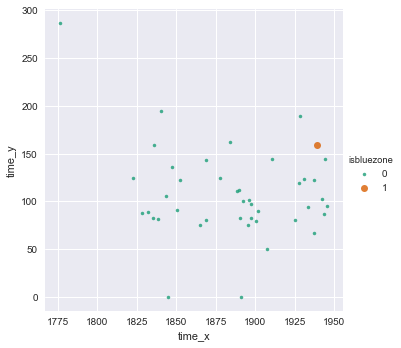

In [31]:
#shading = dict('Bottom'="#9b59b6", 'Top'="#3498db")
ax = sns.lmplot(x='time_x',y='time_y',data=x,hue='isbluezone',markers=['.','o'],fit_reg=False,palette='Dark2')
#ax.set_title('Mean Time of 2nd Place Death by Weapon')
#ax.set_xticklabels(labels=x['weap'],rotation=30)
#ax.set_ylabel('Std (Seconds)')    
#ax.set_xlabel('Mean (Seconds)')
plt.show();

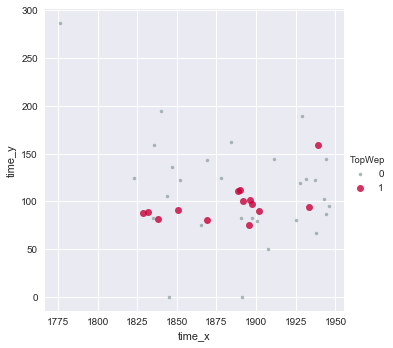

In [32]:
#From the above 
GrRe = ["#95a5a6", "#C70039"]
sns.lmplot(x='time_x',y='time_y',data=x,hue='TopWep',markers=['.','o'],fit_reg=False,palette=GrRe);

In [33]:
TopsOnly = x['time_y'][x['TopWep']==1]
f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(y=TopsOnly,color='darkorange',orient='h',fliersize=20)
ax.set(xlabel='STD of death time (in seconds)')
ax.set_title('STD Time of 2nd Place Death by Weapon')
#ax.set_xticklabels(labels=x['weap'],rotation=30)
#ax.set_ylabel('Std (Seconds)')    
#ax.set_xlabel('Mean (Seconds)')

### We can clearly see that the bluezone is an outlier among the top 14 ways to die in PUBG for the #1 spot. So, what are the characteristics of the players that get 2nd place because of the bluezone? Let's join the tables we've created so far to do some more digging.

In [ ]:
#weps_top[weps_top['weap'] != 'Bluezone']

### Why are so many people dying to the bluezone when it's the most predictable thing in the game? My guess is that many of these players try not to move and wait out a final match in the cities.

In [ ]:
#let's assume that you're more passive than your opponent if you die by
#the bluezone (bz). Given the weapon ranks, are you going to fare better
#if you're a bit more aggressive during the match, specifically if the
#final zone is in a city like XXXXX


In [ ]:
'''
from bokeh.io import show, output_file
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.plotting import figure
from bokeh.transform import factor_cmap

output_file("bar_colormapped.html")

wpns = list(what_wins['weap'])
odds = list(what_wins['odds_over_bz'])

source = ColumnDataSource(data=dict(wpns=wpns, odds=odds))
p = figure(x_range=wpns, plot_height=350,plot_width=1000, toolbar_location=None, title="Weapons Odds over BZ for #1")
p.vbar(x='wpns', top='odds', width=0.5, source=source, legend="wpns",
       line_color='white', fill_color=factor_cmap('wpns', palette=Spectral6, factors=wpns))

p.xgrid.grid_line_color = None
p.y_range.start = -1
p.y_range.end = 3
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
'''

In [34]:
last_death_SP.head()

#_kills  deadly_rank      weap  ratio_kills
0    28117          1.0      M416     0.272758
1    19561          2.0    SCAR-L     0.189758
2     9527          3.0     M16A4     0.092420
3     7948          4.0       AKM     0.077102
4     7566          5.0  Bluezone     0.073396

In [36]:
joined_SP.head()

killed_by killer_name  killer_placement  killer_position_x  \
0       P92      Adlerx              51.0           391919.3   
1       AKM  CocaCola01               4.0           347226.7   
2      P18C    jprodigy              85.0           421634.0   
3  Bluezone         NaN               NaN                NaN   
4      UMP9     MLBBear              30.0           420148.7   

   killer_position_y      map  \
0           235406.2  ERANGEL   
1           142356.4  ERANGEL   
2           324678.9  ERANGEL   
3                NaN  ERANGEL   
4           324679.9  ERANGEL   

                                            match_id  time   victim_name  \
0  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   425      Sventy21   
1  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...  1477  PNW_Franco17   
2  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   126         Eagyl   
3  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   830      Illudian   
4  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...   263       Hastela   

   victim_placement  victim_position_x  victim_position_y  SP  
0              59.0           392289.6           235706.1   1  
1               9.0           345692.8           141435.4   1  
2              86.0           421077.3           324661.9   1  
3              69.0                0.0                0.0   1  
4              71.0           420297.3           326671.7   1

In [ ]:
#winning_shots[winning_shots['deadly_rank'] == 5]

### Let's join the ranking data with the aggregate player data and see what we find regarding characteristics of players who get second place because of the bluezone

In [37]:
winning_shots.columns

NameError: name 'winning_shots' is not defined

In [38]:
#Let's add the rank of weapon kills for a first place finish to the
#first place finish locations by performing an inner join on deaths

winning_shots = pd.merge(x,joined_SP,on='killed_by')
winning_shots_E_bz = winning_shots[(winning_shots['victim_placement'] == 2) 
                                & (winning_shots['map'] == 'ERANGEL')
                                & (winning_shots['killed_by'] == 'Bluezone')]
#winning_shots_E = winning_shots_E.loc[:, winning_shots_E.columns != [['time_x','time_y','TopWep','isbluezone','victim_placement','SP']]]
dfbz = winning_shots_E_bz[['deadly_rank','ratio_kills','TopWep','odds_over_bz','time','victim_position_x','victim_position_y']]
dfbz['xmap'] = dfbz['victim_position_x']*4096/800000
dfbz['ymap'] = dfbz['victim_position_y']*4096/800000
dfbz.describe()

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


deadly_rank   ratio_kills  TopWep  odds_over_bz         time  \
count       7566.0  7.566000e+03  7566.0        7566.0  7566.000000   
mean           5.0  7.339645e-02     1.0           0.0  1939.104414   
std            0.0  1.679323e-15     0.0           0.0   159.349192   
min            5.0  7.339645e-02     1.0           0.0  1059.000000   
25%            5.0  7.339645e-02     1.0           0.0  1872.000000   
50%            5.0  7.339645e-02     1.0           0.0  1892.000000   
75%            5.0  7.339645e-02     1.0           0.0  1978.000000   
max            5.0  7.339645e-02     1.0           0.0  2282.000000   

       victim_position_x  victim_position_y         xmap         ymap  
count        7566.000000        7566.000000  7566.000000  7566.000000  
mean       407047.155867      392738.005849  2084.081438  2010.818590  
std        155226.150542      152763.915368   794.757891   782.151247  
min             0.000000           0.000000     0.000000     0.000000  
25%        290529.475000      279664.750000  1487.510912  1431.883520  
50%        407339.150000      391833.950000  2085.576448  2006.189824  
75%        536006.875000      495328.950000  2744.355200  2536.084224  
max        763021.300000      741918.700000  3906.669056  3798.623744

In [39]:
#Let's add the rank of weapon kills for a first place finish to the
#first place finish locations by performing an inner join on deaths

winning_shots = pd.merge(x,joined_SP,on='killed_by')
winning_shots_E_bz = winning_shots[(winning_shots['victim_placement'] == 2) 
                                & (winning_shots['map'] == 'ERANGEL')]
#winning_shots_E = winning_shots_E.loc[:, winning_shots_E.columns != [['time_x','time_y','TopWep','isbluezone','victim_placement','SP']]]
df1 = winning_shots_E_bz[['deadly_rank','ratio_kills','TopWep','odds_over_bz','time','victim_position_x','victim_position_y']]
df1['xmap'] = dfbz['victim_position_x']*4096/800000
df1['ymap'] = dfbz['victim_position_y']*4096/800000
df1.describe()

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


deadly_rank    ratio_kills         TopWep   odds_over_bz  \
count  103084.000000  103084.000000  103084.000000  103084.000000   
mean        4.640225       0.139346       0.961847       0.898534   
std         4.630297       0.098560       0.191567       1.342850   
min         1.000000       0.000010       0.000000      -0.999868   
25%         1.000000       0.052646       1.000000      -0.282712   
50%         3.000000       0.092420       1.000000       0.259186   
75%         6.000000       0.272758       1.000000       2.716231   
max        47.000000       0.272758       1.000000       2.716231   

                time  victim_position_x  victim_position_y         xmap  \
count  103084.000000      103084.000000      103084.000000  7566.000000   
mean     1893.189962      406087.833076      392273.406175  2084.081438   
std       104.165865      151265.129794      150430.072514   794.757891   
min       979.000000           0.000000           0.000000     0.000000   
25%      1842.000000      289261.800000      280181.750000  1487.510912   
50%      1892.000000      407765.250000      389773.500000  2085.576448   
75%      1955.000000      523687.725000      491663.375000  2744.355200   
max      2374.000000      767453.500000      773166.400000  3906.669056   

              ymap  
count  7566.000000  
mean   2010.818590  
std     782.151247  
min       0.000000  
25%    1431.883520  
50%    2006.189824  
75%    2536.084224  
max    3798.623744

In [40]:
#OK, so now we know the probability that a win happens with someone using a particular weapon.
#let's import everything we need to visualize these winning stats on a map

from scipy.misc.pilutil import imread
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize

### Define Winning Weapon Here

In [41]:
(winning_shots['killed_by'] == 'Bluezone').head()

0    False
1    False
2    False
3    False
4    False
Name: killed_by, dtype: bool

In [42]:
#Let's get the coordinate of the player death for plotting (FOR BLUEZONE ONLY!)

second_place_deaths = np.vstack(dfbz[['victim_position_x','victim_position_y']].values)
#weapon_rank_color = np.vstack(winning_weapon['deadly_rank'].values)
second_place_deaths = second_place_deaths*4096/800000
second_place_deaths

array([[ 1042.318848,  2576.701952],
       [ 2699.835392,  3450.098688],
       [  765.97504 ,  3054.537728],
       ..., 
       [  654.294528,  2113.096704],
       [ 2396.247552,  2042.00192 ],
       [  895.568896,  2125.208576]])

In [315]:
#Let's make a map with deaths plotted as a scatter, each death colored by 
#the weapon responsible for the win!

def heatmap(x, y, s, bins=1):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

erangel = imread(pics +'erangel_bw.jpg')

hmap, extent = heatmap(second_place_deaths[:,0], second_place_deaths[:,1], 1.5)
alphas = np.clip(Normalize(0, hmap.max(), clip=True)(hmap)*1.5, 0.0, 1.)
colors = Normalize(0, hmap.max(), clip=True)(hmap)
colors = cm.Reds(colors)
colors[..., -1] = alphas

fig, ax = plt.subplots(figsize=(24,24))
ax.set_xlim(0, 4096); ax.set_ylim(0, 4096)
ax.imshow(colors, extent=extent, origin='lower', cmap=cm.Reds, alpha=0.5)


#cr = [i+x+(i*x)**2 for i in plot_data_er_second['deadly_rank']]

#colors = cm.rainbow(np.linspace(0, 1, len(ys)))
#for y, c in zip(ys, colors):
   #plt.scatter(x, y, color=c)

xs = second_place_deaths[:,0]
ys = second_place_deaths[:,1]
qs = second_place_deaths
pochinki = [(qs[:,0] < 1900) & (qs[:,0] > 1750) & (qs[:,1] > 1950) & (qs[:,1] < 2100)]

'''Roznok

Severny

Lipovka

Mylta

Novorepnoye

Gatka

Primorsk

Georgopol_S

Georgopol_N'''





yasnaya = 1

#N = 2
#plot_data_er_second = plot_data_er_second[plot_data_er_second['deadly_rank'] == N]
plt.scatter(xs, ys,s=20,alpha=0.35,color='#33FFBD')
plt.hexbin(second_place_deaths[:,0], second_place_deaths[:,1],
           gridsize=190,bins=2,alpha=.4,C=second_place_deaths[:,0],cmap = 'tab10') #BZ undermap

plt.scatter(xs[(qs[:,0] < 1900) & (qs[:,0] > 1750) & (qs[:,1] > 1950) & (qs[:,1] < 2100)], 
            ys[(qs[:,0] < 1900) & (qs[:,0] > 1750) & (qs[:,1] > 1950) & (qs[:,1] < 2100)], 
            alpha=0.9, 
            color='#FF5733') #color map Pochinki

plt.scatter(xs[(qs[:,0] < 2850) & (qs[:,0] > 2600) & (qs[:,1] > 1100) & (qs[:,1] < 1280)], 
            ys[(qs[:,0] < 2850) & (qs[:,0] > 2600) & (qs[:,1] > 1100) & (qs[:,1] < 1280)], 
            alpha=0.9, 
            color='#FF00FF') #color map Yasnaya

plt.scatter(xs[(qs[:,0] < 1100) & (qs[:,0] > 600) & (qs[:,1] > 1050) & (qs[:,1] < 1250)], 
            ys[(qs[:,0] < 1100) & (qs[:,0] > 600) & (qs[:,1] > 1050) & (qs[:,1] < 1250)], 
            alpha=0.9, 
            color='#FDFD06') #Georgopol_N

plt.scatter(xs[(qs[:,0] < 1100) & (qs[:,0] > 600) & (qs[:,1] > 1350) & (qs[:,1] < 1550)], 
            ys[(qs[:,0] < 1100) & (qs[:,0] > 600) & (qs[:,1] > 1350) & (qs[:,1] < 1550)], 
            alpha=0.9,
            color='#FDFD06') #Georgopol_S

plt.scatter(xs[(qs[:,0] < 1000) & (qs[:,0] > 600) & (qs[:,1] > 3000) & (qs[:,1] < 3300)], 
            ys[(qs[:,0] < 1000) & (qs[:,0] > 600) & (qs[:,1] > 3000) & (qs[:,1] < 3300)], 
            alpha=0.9, 
            color='#FDFD06') #Primrosk

plt.scatter(xs[(qs[:,0] < 2150) & (qs[:,0] > 1950) & (qs[:,1] > 1350) & (qs[:,1] < 1550)], 
            ys[(qs[:,0] < 2150) & (qs[:,0] > 1950) & (qs[:,1] > 1350) & (qs[:,1] < 1550)], 
            alpha=0.9,
            color='#FDFD06') #Roznok

plt.scatter(xs[(qs[:,0] < 2000) & (qs[:,0] > 1850) & (qs[:,1] > 350) & (qs[:,1] < 750)], 
            ys[(qs[:,0] < 2000) & (qs[:,0] > 1850) & (qs[:,1] > 350) & (qs[:,1] < 750)], 
            alpha=0.9,
            color='#FDFD06') #Severny

plt.scatter(xs[(qs[:,0] < 3150) & (qs[:,0] > 2900) & (qs[:,1] > 2300) & (qs[:,1] < 2600)], 
            ys[(qs[:,0] < 3150) & (qs[:,0] > 2900) & (qs[:,1] > 2300) & (qs[:,1] < 2600)], 
            alpha=0.9, 
            color='#FDFD06') #Mylta

plt.scatter(xs[(qs[:,0] < 1200) & (qs[:,0] > 1050) & (qs[:,1] > 1900) & (qs[:,1] < 2100)], 
            ys[(qs[:,0] < 1200) & (qs[:,0] > 1050) & (qs[:,1] > 1900) & (qs[:,1] < 2100)], 
            alpha=0.9,
            color='#FDFD06') #Gatka

plt.scatter(xs[(qs[:,0] < 2500) & (qs[:,0] > 2000) & (qs[:,1] > 3100) & (qs[:,1] < 3400)], 
            ys[(qs[:,0] < 2500) & (qs[:,0] > 2000) & (qs[:,1] > 3100) & (qs[:,1] < 3400)], 
            alpha=0.9,
            color='#FDFD06') #Sosnovka Military Base

plt.scatter(xs[(qs[:,0] < 3200) & (qs[:,0] > 3000) & (qs[:,1] > 2800) & (qs[:,1] < 3200)], 
            ys[(qs[:,0] < 3200) & (qs[:,0] > 3000) & (qs[:,1] > 2800) & (qs[:,1] < 3200)], 
            alpha=0.9,
            color='#FDFD06') #Novorepnoye

plt.scatter(xs[(qs[:,0] < 3700) & (qs[:,0] > 3500) & (qs[:,1] > 1550) & (qs[:,1] < 1850)], 
            ys[(qs[:,0] < 3700) & (qs[:,0] > 3500) & (qs[:,1] > 1550) & (qs[:,1] < 1850)], 
            alpha=0.9, 
            color='#FDFD06') #Lipovka

plt.scatter(xs[(qs[:,0] < 3850) & (qs[:,0] > 3550) & (qs[:,1] > 2050) & (qs[:,1] < 2400)], 
            ys[(qs[:,0] < 3850) & (qs[:,0] > 3550) & (qs[:,1] > 2050) & (qs[:,1] < 2400)], 
            alpha=0.9, 
            color='#FDFD06') #Mylta Power




#plt.scatter(second_place_deaths[:,0]+10, second_place_deaths[:,1]-13,alpha=0.3,color='red')
#plt.hexbin(plot_data_er_second[:,0], plot_data_er_second[:,1],gridsize=75,bins=1,alpha=.7,C=(plot_data_er_second[:,0]))





#g = sns.jointplot(plot_data_er_second[:,0], plot_data_er_second[:,1], data=plot_data_er_second, kind="kde", color="orange",space=.1,n_levels=20)
#g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
#g.ax_joint.collections[0].set_alpha(0)
#g.set_axis_labels("$X$", "$Y$")


ax.imshow(erangel)
plt.gca().invert_yaxis()

In [306]:
#cool. now let's see if we can isolate the coordinates for one of the cities. Let's pick Pochinki
pochinki_bz = dfbz[(dfbz['xmap'] < 1900) & (dfbz['xmap'] > 1750) & (dfbz['ymap'] > 1950) & (dfbz['ymap'] < 2100)]
yasnaya_bz = dfbz[(dfbz['xmap'] < 2850) & (dfbz['xmap'] > 2600) & (dfbz['ymap'] > 1100) & (dfbz['ymap'] < 1280)]
georgeN_bz = dfbz[(dfbz['xmap'] < 1100) & (dfbz['xmap'] > 600) & (dfbz['ymap'] > 1050) & (dfbz['ymap'] < 1250)]
georgeS_bz = dfbz[(dfbz['xmap'] < 1100) & (dfbz['xmap'] > 600) & (dfbz['ymap'] > 1350) & (dfbz['ymap'] < 1550)]
primrosk_bz = dfbz[(dfbz['xmap'] < 1000) & (dfbz['xmap'] > 600) & (dfbz['ymap'] > 3000) & (dfbz['ymap'] < 3300)]
roznok_bz = dfbz[(dfbz['xmap'] < 2150) & (dfbz['xmap'] > 1950) & (dfbz['ymap'] > 1350) & (dfbz['ymap'] < 1550)]
severny_bz = dfbz[(dfbz['xmap'] < 2000) & (dfbz['xmap'] > 1850) & (dfbz['ymap'] > 350) & (dfbz['ymap'] < 750)]
mylta_bz = dfbz[(dfbz['xmap'] < 3150) & (dfbz['xmap'] > 2900) & (dfbz['ymap'] > 2300) & (dfbz['ymap'] < 2600)]
gatka_bz = dfbz[(dfbz['xmap'] < 1200) & (dfbz['xmap'] > 1050) & (dfbz['ymap'] > 1900) & (dfbz['ymap'] < 2100)]
milbase_bz = dfbz[(dfbz['xmap'] < 2500) & (dfbz['xmap'] > 2000) & (dfbz['ymap'] > 3100) & (dfbz['ymap'] < 3400)]
novor_bz = dfbz[(dfbz['xmap'] < 3200) & (dfbz['xmap'] > 3000) & (dfbz['ymap'] > 2800) & (dfbz['ymap'] < 3200)]
lipov_bz = dfbz[(dfbz['xmap'] < 3700) & (dfbz['xmap'] > 3500) & (dfbz['ymap'] > 1550) & (dfbz['ymap'] < 1850)]
power_bz = dfbz[(dfbz['xmap'] < 3850) & (dfbz['xmap'] > 3550) & (dfbz['ymap'] > 2050) & (dfbz['ymap'] < 2400)]

count_all_bzcity = (pochinki_bz['victim_position_x'].count()+
      yasnaya_bz['victim_position_x'].count() + georgeN_bz['victim_position_x'].count() + georgeS_bz['victim_position_x'].count()+
      primrosk_bz['victim_position_x'].count() + roznok_bz['victim_position_x'].count() + severny_bz['victim_position_x'].count()+
      mylta_bz['victim_position_x'].count()+gatka_bz['victim_position_x'].count()+milbase_bz['victim_position_x'].count()+
      novor_bz['victim_position_x'].count()+lipov_bz['victim_position_x'].count()+power_bz['victim_position_x'].count())

#pochinki_all = 
#sdf = df1[(df1['xmap'] < 1900)]
#how many people died to the bluezone in pochinki?
print ('Death by Bluezone in Erangel: ',dfbz['victim_position_x'].count())
print ('\nDeath by Bluezone in Pochinki: ',pochinki_bz['victim_position_x'].count())
print ('Death by Bluezone in Yasnaya Polyana: ',yasnaya_bz['victim_position_x'].count())
print ('Death by Bluezone in Georgeopol: ',georgeN_bz['victim_position_x'].count() + georgeS_bz['victim_position_x'].count() )
print ('Death by Bluezone in Primrosk: ',primrosk_bz['victim_position_x'].count())
print ('Death by Bluezone in Roznok: ',roznok_bz['victim_position_x'].count())
print ('Death by Bluezone in Severny: ',severny_bz['victim_position_x'].count())
print ('Death by Bluezone in Mylta: ',mylta_bz['victim_position_x'].count())
print ('Death by Bluezone in Gatka: ',gatka_bz['victim_position_x'].count())
print ('Death by Bluezone in Sosnovka Military Base: ',milbase_bz['victim_position_x'].count())
print ('Death by Bluezone in Novorepnoye: ',novor_bz['victim_position_x'].count())
print ('Death by Bluezone in Lipovka: ',lipov_bz['victim_position_x'].count())
print ('Death by Bluezone in Mylta Power: ',power_bz['victim_position_x'].count())

print ('\n\tDeath by Bluezone in Named Cities: ',pochinki_bz['victim_position_x'].count()+
      yasnaya_bz['victim_position_x'].count() + georgeN_bz['victim_position_x'].count() + georgeS_bz['victim_position_x'].count()+
      primrosk_bz['victim_position_x'].count() + roznok_bz['victim_position_x'].count() + severny_bz['victim_position_x'].count()+
      mylta_bz['victim_position_x'].count()+gatka_bz['victim_position_x'].count()+milbase_bz['victim_position_x'].count()+
      novor_bz['victim_position_x'].count()+lipov_bz['victim_position_x'].count()+power_bz['victim_position_x'].count())

city_bz_ratio = (count_all_bzcity / dfbz['victim_position_x'].count())*100
       
print ('\n\tRatio of all Erangel bluezone deaths occured in cities: ','%.2f' % city_bz_ratio,'%')

Death by Bluezone in Erangel:  7566

Death by Bluezone in Pochinki:  82
Death by Bluezone in Yasnaya Polyana:  141
Death by Bluezone in Georgeopol:  218
Death by Bluezone in Primrosk:  42
Death by Bluezone in Roznok:  76
Death by Bluezone in Severny:  68
Death by Bluezone in Mylta:  119
Death by Bluezone in Gatka:  40
Death by Bluezone in Sosnovka Military Base:  189
Death by Bluezone in Novorepnoye:  37
Death by Bluezone in Lipovka:  33
Death by Bluezone in Mylta Power:  53

	Death by Bluezone in Named Cities:  1098

	Ratio of all Erangel bluezone deaths occured in cities:  14.51 %


### Let's add the coordinates of every 2nd place death for every weapon...

In [124]:
winning_shots.columns

Index(['deadly_rank', 'ratio_kills', 'killed_by', 'time_x', 'time_y', 'TopWep',
       'isbluezone', 'odds_over_bz', 'killer_name', 'killer_placement',
       'killer_position_x', 'killer_position_y', 'map', 'match_id', 'time',
       'victim_name', 'victim_placement', 'victim_position_x',
       'victim_position_y', 'SP'],
      dtype='object')

In [123]:
winning_shots_E_All = winning_shots[(winning_shots['victim_placement'] == 2) 
                                & (winning_shots['map'] == 'ERANGEL')]

#winning_shots_E = winning_shots_E.loc[:, winning_shots_E.columns != [['time_x','time_y','TopWep','isbluezone','victim_placement','SP']]]
df_All = winning_shots_E_All[['killed_by','deadly_rank','ratio_kills','TopWep','odds_over_bz','time','victim_position_x','victim_position_y']]
df_All['xmap'] = df_All['victim_position_x']*4096/800000
df_All['ymap'] = df_All['victim_position_y']*4096/800000
df_All1 = df_All[['TopWep','killed_by','victim_position_x']].groupby('killed_by').count().sort_values(['victim_position_x'],ascending=False)
#wm = wep_time.groupby('killed_by',as_index=False).mean()

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [125]:
df_All.columns

Index(['killed_by', 'deadly_rank', 'ratio_kills', 'TopWep', 'odds_over_bz',
       'time', 'victim_position_x', 'victim_position_y', 'xmap', 'ymap'],
      dtype='object')

In [126]:
#how many 2nd place deaths occur in Pochinki?
winning_shots_E_Pochinki = df_All[(df_All['xmap'] < 1900) 
                                & (df_All['xmap'] > 1750) 
                                & (df_All['ymap'] > 1950) 
                                & (df_All['ymap'] < 2100)]
#how many 2nd place deaths occur in Yasnaya?
winning_shots_E_Yasnaya = df_All[(df_All['xmap'] < 2850) 
                                & (df_All['xmap'] > 2600) 
                                & (df_All['ymap'] > 1100) 
                                & (df_All['ymap'] < 1280)]
#let's create a dataframe with these site deaths loaded into it
df_PK = winning_shots_E_Pochinki[['killed_by','deadly_rank','ratio_kills','TopWep','odds_over_bz','time','victim_position_x','victim_position_y']]
df_YS = winning_shots_E_Yasnaya[['killed_by','deadly_rank','ratio_kills','TopWep','odds_over_bz','time','victim_position_x','victim_position_y']] 

#convert death sites to proper map coordinates
df_PK['xmap'] = df_PK['victim_position_x']*4096/800000
df_PK['ymap'] = df_PK['victim_position_y']*4096/800000
df_YS['xmap'] = df_YS['victim_position_x']*4096/800000
df_YS['ymap'] = df_YS['victim_position_y']*4096/800000

df_PK1 = df_PK[['killed_by','victim_position_x']].groupby(('killed_by')).count().sort_values(['victim_position_x'],ascending=False)
df_YS1 = df_YS[['killed_by','victim_position_x']].groupby(('killed_by')).count().sort_values(['victim_position_x'],ascending=False)

C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Jacek\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [127]:
#wow... Bluezone is even more deadly in Yasnaya!
df_YS1.head()

victim_position_x
killed_by                   
M416                     190
Bluezone                 141
SCAR-L                   101
AKM                       50
M16A4                     48

In [875]:
df_PK1.columns

Index(['victim_position_x'], dtype='object')

103084

In [219]:
pochinki_deaths = pd.merge(df_PK1,df_All1,left_index=True,right_index=True)


#bz_risk = float(weps_top_N.loc[weps_top_N['weap'] == 'Bluezone','ratio_kills']) 

pochinki_deaths['ratio'] = pochinki_deaths['victim_position_x_x'] / pochinki_deaths['victim_position_x_y']

pkbr = float(pochinki_deaths.iloc[2:3]['ratio'])
pochinki_deaths['bz_risk'] = pochinki_deaths['ratio'] / pkbr
total_pochinki_2pdeaths = pochinki_deaths['victim_position_x_x'].sum() # total 2nd place deaths in pochinki
total_erangel_2pdeaths = winning_shots_E_All['killed_by'].count() # total 2nd place deaths in Erangel
pochinki_deaths['pktot_ratio'] = pochinki_deaths['victim_position_x_x'] / total_pochinki_2pdeaths 
pochinki_deaths = pochinki_deaths.loc[:, pochinki_deaths.columns != ('TopWep')]
pochinki_deaths.columns = ['deaths_PK', 'deaths_E','ratio_deaths_PK','bz_risk','pktot_ratio']
pochinki_deaths['RR'] = pochinki_deaths['ratio_deaths_PK']*pochinki_deaths['pktot_ratio']
pochinki_deaths['log_RR'] = np.log(pochinki_deaths['RR'])
pochinki_deaths['PK_to_E_deathratio'] = total_pochinki_2pdeaths / total_erangel_2pdeaths
pochinki_deaths['pred_deaths'] = pochinki_deaths['deaths_E'] * pochinki_deaths['PK_to_E_deathratio']
pochinki_deaths['weap_risk_pk'] = pochinki_deaths['deaths_PK'] / pochinki_deaths['pred_deaths'] #actual/pred deaths
pochinki_deaths['weap_riskreal_pk'] = pochinki_deaths['weap_risk_pk'] * pochinki_deaths['pktot_ratio'] #prob death in pk by wep * real game deaths ratio
#pochinki_deaths['weap_risk_rank_pk'] = pochinki_deaths['weap_risk_pk'].rank(ascending=False)
pochinki_deaths.reset_index(level=0, inplace=True)
pochinki_deaths.head()

killed_by  deaths_PK  deaths_E  ratio_deaths_PK   bz_risk  pktot_ratio  \
0      M416        119     28117         0.004232  0.390508     0.263858   
1    SCAR-L         85     19561         0.004345  0.400941     0.188470   
2  Bluezone         82      7566         0.010838  1.000000     0.181818   
3       AKM         34      7948         0.004278  0.394706     0.075388   
4     M16A4         32      9527         0.003359  0.309918     0.070953   

         RR    log_RR  PK_to_E_deathratio  pred_deaths  weap_risk_pk  \
0  0.001117 -6.797350            0.004375   123.013921      0.967370   
1  0.000819 -7.107458            0.004375    85.580798      0.993213   
2  0.001971 -6.229449            0.004375    33.101800      2.477207   
3  0.000322 -8.039422            0.004375    34.773078      0.977768   
4  0.000238 -8.341881            0.004375    41.681318      0.767730   

   weap_riskreal_pk  
0          0.255248  
1          0.187191  
2          0.450401  
3          0.073712  
4          0.054473

In [220]:
#let's extract the Pochinki Weapon Stats for later use
pochinki_deaths.to_csv('Pochinki_weapon_data.csv',sep=",")

In [222]:
yasnaya_deaths = pd.merge(df_YS1,df_All1,left_index=True,right_index=True)


#bz_risk = float(weps_top_N.loc[weps_top_N['weap'] == 'Bluezone','ratio_kills']) 

yasnaya_deaths['ratio'] = yasnaya_deaths['victim_position_x_x'] / yasnaya_deaths['victim_position_x_y']

ysbr = float(yasnaya_deaths.iloc[2:3]['ratio'])
yasnaya_deaths['ysbz_risk'] = yasnaya_deaths['ratio'] / ysbr
total_yasnaya_2pdeaths = yasnaya_deaths['victim_position_x_x'].sum() # total 2nd place deaths in yasnaya
total_erangel_2pdeaths = winning_shots_E_All['killed_by'].count() # total 2nd place deaths in Erangel
yasnaya_deaths['ystot_ratio'] = yasnaya_deaths['victim_position_x_x'] / total_yasnaya_2pdeaths 
yasnaya_deaths = yasnaya_deaths.loc[:, yasnaya_deaths.columns != ('TopWep')]
yasnaya_deaths.columns = ['deaths_YS', 'deaths_E','ratio_deaths_YS','ysbz_risk','ystot_ratio']
yasnaya_deaths['ysRR'] = yasnaya_deaths['ratio_deaths_YS']*yasnaya_deaths['ystot_ratio']
yasnaya_deaths['log_ysRR'] = np.log(yasnaya_deaths['ysRR'])
yasnaya_deaths['YS_to_E_deathratio'] = total_yasnaya_2pdeaths / total_erangel_2pdeaths
yasnaya_deaths['pred_deaths_ys'] = yasnaya_deaths['deaths_E'] * yasnaya_deaths['YS_to_E_deathratio']
yasnaya_deaths['weap_risk_ys'] = yasnaya_deaths['deaths_YS'] / yasnaya_deaths['pred_deaths_ys'] #actual/pred deaths
yasnaya_deaths['weap_riskreal_ys'] = yasnaya_deaths['weap_risk_ys'] * yasnaya_deaths['ystot_ratio'] #prob death in pk by wep * real game deaths ratio
#yasnaya_deaths['weap_risk_rank_ys'] = yasnaya_deaths['weap_risk_ys'].rank(ascending=False)
yasnaya_deaths.reset_index(level=0, inplace=True)
yasnaya_deaths.head()

killed_by  deaths_YS  deaths_E  ratio_deaths_YS  ysbz_risk  ystot_ratio  \
0      M416        190     28117         0.006757   1.308743     0.284006   
1  Bluezone        141      7566         0.018636   3.609296     0.210762   
2    SCAR-L        101     19561         0.005163   1.000000     0.150972   
3       AKM         50      7948         0.006291   1.218377     0.074738   
4     M16A4         48      9527         0.005038   0.975786     0.071749   

       ysRR  log_ysRR  YS_to_E_deathratio  pred_deaths_ys  weap_risk_ys  \
0  0.001919 -6.255866             0.00649      182.475195      1.041237   
1  0.003928 -5.539684             0.00649       49.102227      2.871560   
2  0.000780 -7.156836             0.00649      126.948013      0.795601   
3  0.000470 -7.662414             0.00649       51.581351      0.969343   
4  0.000361 -7.925267             0.00649       61.828829      0.776337   

   weap_riskreal_ys  
0          0.295718  
1          0.605217  
2          0.120113  
3          0.072447  
4          0.055701

In [223]:
#let's extract the Pochinki Weapon Stats for later use
yasnaya_deaths.to_csv('Yasnaya_weapon_data.csv',sep=",")

In [131]:
total_erangel_2pdeaths

103084

In [139]:
yasnaya_deaths.deaths_YS.sum()

669

In [ ]:
#GA_Final_Analysis_Export.to_csv('GA_final_proj_data.csv',sep=",")

killed_by  pktot_ratio
0      M416     0.263858
1    SCAR-L     0.188470
2  Bluezone     0.181818
3       AKM     0.075388
4     M16A4     0.070953
5   Grenade     0.035477
6     Groza     0.031042
7      UMP9     0.026608
8    Kar98k     0.022173
9   Mini 14     0.013304

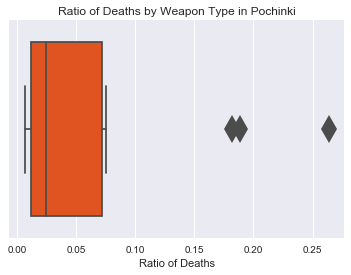

In [307]:
#sns.lmplot(x='bz_risk',y='RR',data=pochinki_deaths,size=10)
ax = sns.boxplot(y='pktot_ratio',data=pochinki_deaths[pochinki_deaths['pktot_ratio'] > 0.005],
            color='orangered',orient='h',fliersize=20)
ax.set(xlabel='Ratio of Deaths')
ax.set_title('Ratio of Deaths by Weapon Type in Pochinki')
pd.DataFrame(pochinki_deaths[['killed_by','pktot_ratio']].head(10))

killed_by  ystot_ratio
0      M416     0.284006
1  Bluezone     0.210762
2    SCAR-L     0.150972
3       AKM     0.074738
4     M16A4     0.071749
5   Grenade     0.050822
6     Groza     0.022422
7      UMP9     0.022422
8   Mini 14     0.017937
9    Kar98k     0.016442

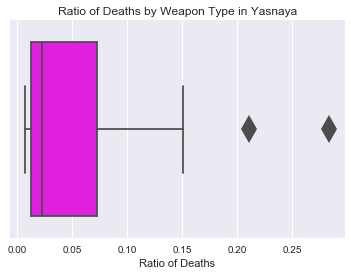

In [309]:
ax = sns.boxplot(y='ystot_ratio',data=yasnaya_deaths[yasnaya_deaths['ystot_ratio'] > 0.005],
            color='fuchsia',orient='h',fliersize=20);
ax.set(xlabel='Ratio of Deaths')
ax.set_title('Ratio of Deaths by Weapon Type in Yasnaya')
pd.DataFrame(yasnaya_deaths[['killed_by','ystot_ratio']].head(10))

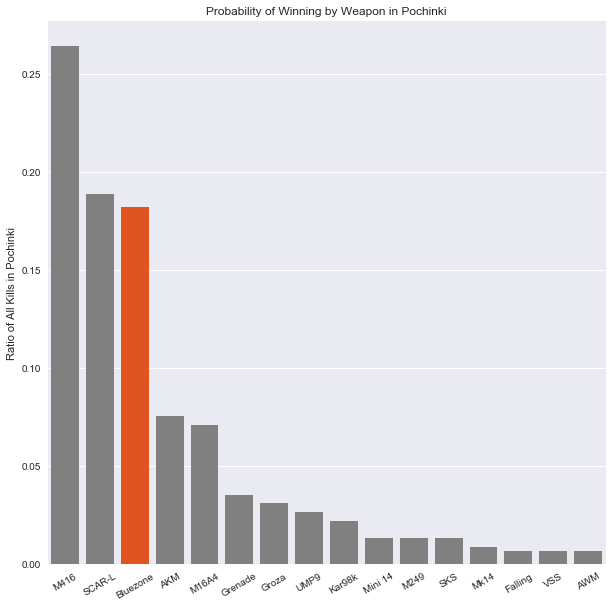

In [217]:
plt.subplots(figsize=(10,10))
values = pochinki_deaths['killed_by'] 
clrs = ['grey' if (x != 'Bluezone') else 'orangered' for x in values ]
clrs2 = ['grey' if (x != 'Bluezone') else 'red' for x in values ]

ax = sns.barplot(x='killed_by',y='pktot_ratio',data=pochinki_deaths[pochinki_deaths['pktot_ratio'] > 0.005],palette=clrs)
ax.set_title('Probability of Winning by Weapon in Pochinki')
ax.set_xticklabels(labels=wep_rank['weap'],rotation=30)
ax.set_ylabel('Ratio of All Kills in Pochinki')    
ax.set_xlabel('')
ax.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show();

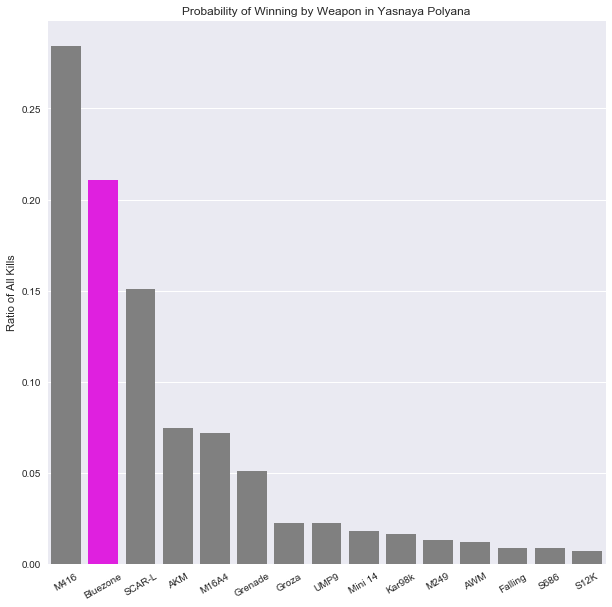

In [193]:
plt.subplots(figsize=(10,10))
values2 = yasnaya_deaths['killed_by']
clrs3 = ['grey' if (x != 'Bluezone') else 'fuchsia' for x in values2 ]

ax = sns.barplot(x='killed_by',y='ystot_ratio',data=yasnaya_deaths[yasnaya_deaths['ystot_ratio'] > 0.005],palette=clrs3)
ax.set_title('Probability of Winning by Weapon in Yasnaya Polyana')
ax.set_xticklabels(labels=wep_rank['weap'],rotation=30)
ax.set_ylabel('Ratio of All Kills')    
ax.set_xlabel('')
ax.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show();


In [311]:
#wait a minute, did you see the above results? Deaths by bluezone happen WAAAAAAY more often in pochinki than they would otherwise be predicted.
plt.subplots(figsize=(10,10))
values = pochinki_deaths['killed_by'] 

ax = sns.barplot(x='killed_by',y='weap_riskreal_pk',data=pochinki_deaths[pochinki_deaths['pktot_ratio'] > 0.005],palette=clrs2)
ax.set_xticklabels(g.get_xticklabels(), rotation=30);

ax.set_title('Real Risk of Bluezone: Pochinki')
ax.set_xticklabels(labels=wep_rank['weap'],rotation=30)
ax.set_ylabel('Real Risk Ratio')    
ax.set_xlabel('')
ax.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show();


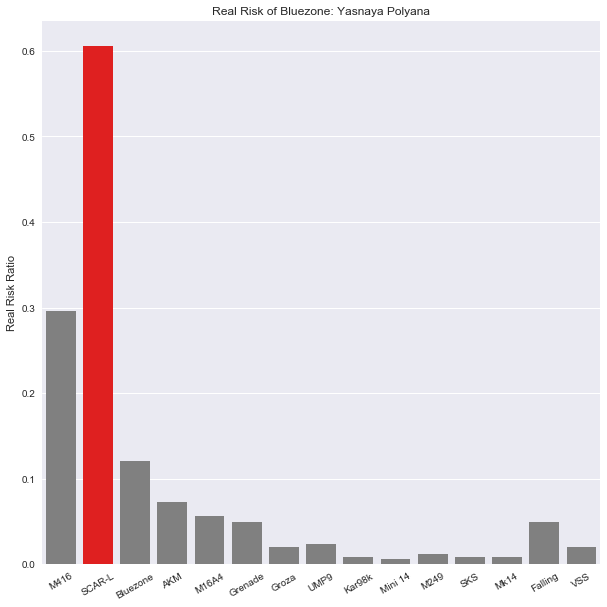

In [312]:

#wait a minute, did you see the above results? Deaths by bluezone happen WAAAAAAY more often in pochinki than they would otherwise be predicted.
plt.subplots(figsize=(10,10))
values2 = yasnaya_deaths['killed_by'] 
clrs2 = ['grey' if (x != 'Bluezone') else 'red' for x in values2 ]

ax = sns.barplot(x='killed_by',y='weap_riskreal_ys',data=yasnaya_deaths[yasnaya_deaths['ystot_ratio'] > 0.005],palette=clrs2)
ax.set_xticklabels(g.get_xticklabels(), rotation=30);

ax.set_title('Real Risk of Bluezone: Yasnaya Polyana')
ax.set_xticklabels(labels=wep_rank['weap'],rotation=30)
ax.set_ylabel('Real Risk Ratio')    
ax.set_xlabel('')
ax.set_xticklabels(g.get_xticklabels(), rotation=30)
plt.show();

### Insights 

    1) Approx 1% of all Erangel- 2nd place deaths by bluezone happen in Pochinki, and bluezone deaths constitute a whopping  18% of all 2nd place Pochinki deaths in the time period! It's the 3rd deadliest way to go in that city! How often is it that the bluezone ends there?

    2) Even more supportive of the initial hypothesis is that, ~2% of all Erangel- 2nd place deaths by bluezone happen in   
     Yasnaya Polyana, and bluezone deaths constitute a whopping 21% of all 2nd place Yasnaya deaths in the time period! How often is it that the bluezone ends there?

### Predictions
    1) Bluezone deaths constitute more than 15% of all deaths in a 1v1 for the win in ANY city on Erangel. Seems to be the   case!

    2) Bluezone deaths happen to more passive players and we can use ML tools to help us group their characteristics. These players are most likely new or just too frightened/anxious to move?!??


### Exploratory Analysis Takeaway

You'd probably INCREASE your chance of winning if the final circle came down to Pochinki OR Yasnaya by adopting an aggressive playstyle and making sure not to camp out! At the very least, make sure you have ample options of getting out of your hiding spot once the bluezone starts moving. Hiding in buildings within cities may help increase your chances of winning early on in a match, but the risk of losing because of the bluezone really increases in a 1v1 fight for the win.

Those who die by bluezone are most likely not aggressive enough. They could have made it to the end by camping and mostly avoiding fights (as evidenced by the analysis of their total mileage + kills + KOs in a match), but hiding doesn't help when you want to win!

## Let's create a usable extract for our predictive models

Here's what we're going to take

aggsforDS

    1) aggs.player_name (keep to confirm 2nd place finisher ID)
    2) aggs.match_id (KEY)
    3) aggs.match_mode
    4) aggs.party_size == 1
    5) aggs.game_size
    6) aggs.player_assists
    7) aggs.player_dbno
    8) aggs.player_kills
    9) aggs.player_dmg
    10) aggs.player_dist_walk
    
    join on match_id+player_name

deathsforDS

    1) deaths.map == 'ERANGEL'
    2) deaths.match_id (KEY)
    3) deaths.victim_name (keep to confirm 2nd place finisher ID)
    4) deaths.victim_placement == 2
    5) deaths.victim_position_x
    6) deaths.victim_position_y
    
We only need to use the match_id as our key because there is always 1x 2nd place finsher in each map. Sure, we can grab player name as well, but that would needlessly complicate things.

In [186]:
aggsforDS = aggs.loc[:, aggs.columns != ('team_id','date','player_dist_ride','player_survive_time','team_placement')][(aggs['party_size'] == 1) & (aggs['team_placement'] == 2)]
#aggsforDS = pd.DataFrame(aggs[(aggs['match_mode'] == 'SP') ])


In [187]:
aggsforDS.head()

date  game_size  \
533   2017-11-19T08:28:59+0000         91   
934   2017-11-21T06:55:35+0000         94   
2292  2017-12-06T00:39:03+0000         95   
2353  2017-12-17T06:37:50+0000         63   
2487  2017-11-11T09:34:22+0000         85   

                                               match_id match_mode  \
533   2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...        tpp   
934   2U4GBNA0YmnMiL8FxzK-xRalmDs8__VvvNzmntjlIzBi0D...        tpp   
2292  2U4GBNA0YmnNOKktVk9Qv5ZxUnnxXk1-kUI03yF8vbYyzd...        tpp   
2353  2U4GBNA0YmmyNWABCuuEotdFnf2pYAu3C5f-JJ9Qv-UyQV...        tpp   
2487  2U4GBNA0YmkRFnEnlar5FbJrM9fzxmAkpXnhkbdlw89MM6...        tpp   

      party_size  player_assists  player_dbno  player_dist_ride  \
533            1               1            0        3262.99854   
934            1               0            0        2098.33600   
2292           1               0            0        4887.38770   
2353           1               0            0        1488.72107   
2487           1               0            0        2630.64600   

      player_dist_walk  player_dmg  player_kills   player_name  \
533         1813.36450         186             0      anbo1349   
934         1287.92285         217             1        Quziye   
2292        2403.10352          52             0  Jamesnadu007   
2353        4033.27979         175             2  HKCon_Dom001   
2487        2300.88574         474             3   fyrentattoo   

      player_survive_time  team_id  team_placement  
533              1958.794   100049               2  
934              1883.838   100090               2  
2292             1881.415   100035               2  
2353             1885.232   100096               2  
2487             1875.549   100044               2

In [28]:
#deathsforDS[deathsforDS.loc[:, deathsforDS.columns != ('killer_name','killer_placement','killer_position_x','killer_position_y')]]

In [188]:
deaths.columns

Index(['killed_by', 'killer_name', 'killer_placement', 'killer_position_x',
       'killer_position_y', 'map', 'match_id', 'time', 'victim_name',
       'victim_placement', 'victim_position_x', 'victim_position_y'],
      dtype='object')

### The loser's table

For our DS initiativ, we'll need to assume that the player has at least 1 kill so taht they're entering the match with a weapon in hand. We'll take the weapon they last used to kill another player with and the distance from their death site as additional factors. We need to create a table that takes this into account.

In [ ]:
deaths.columns

In [242]:
#get losers last kill weapon used
#get loser's last coord with last kill weapon used
#get the winner's 
#get distance from loser death site at last loser's kill



sum_kills_second = pd.DataFrame(deaths[(deaths['map'] == 'ERANGEL') & (deaths['killer_placement'] == 2)])

last_kill_second = (sum_kills_second.sort_values(['time'], ascending=False)
             .drop_duplicates(['match_id']).reset_index(drop=True)
          )
last_kill_second.shape


(442173, 12)

In [243]:
last_kill_second.to_csv('last_kill_second.csv',sep=",")

In [189]:
deathsforDS = pd.DataFrame(deaths.loc[:, deaths.columns != ('time','killer_name','killer_placement','killer_position_x','killer_position_y')][(deaths['map'] == 'ERANGEL') 
                                                                     & (deaths['victim_placement'] == 2)])

In [190]:
GA_Final_Analysis_Export = pd.merge(aggsforDS,deathsforDS,on='match_id',how='inner')
GA_Final_Analysis_Export.to_csv('GA_final_proj_data.csv',sep=",")

In [32]:
GA_Final_Analysis_Export.head()

date  game_size  \
0  2017-11-19T08:28:59+0000         91   
1  2017-11-21T06:55:35+0000         94   
2  2017-12-06T00:39:03+0000         95   
3  2017-12-17T06:37:50+0000         63   
4  2017-11-11T09:34:22+0000         85   

                                            match_id match_mode  party_size  \
0  2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...        tpp           1   
1  2U4GBNA0YmnMiL8FxzK-xRalmDs8__VvvNzmntjlIzBi0D...        tpp           1   
2  2U4GBNA0YmnNOKktVk9Qv5ZxUnnxXk1-kUI03yF8vbYyzd...        tpp           1   
3  2U4GBNA0YmmyNWABCuuEotdFnf2pYAu3C5f-JJ9Qv-UyQV...        tpp           1   
4  2U4GBNA0YmkRFnEnlar5FbJrM9fzxmAkpXnhkbdlw89MM6...        tpp           1   

   player_assists  player_dbno  player_dist_ride  player_dist_walk  \
0               1            0        3262.99854        1813.36450   
1               0            0        2098.33600        1287.92285   
2               0            0        4887.38770        2403.10352   
3               0            0        1488.72107        4033.27979   
4               0            0        2630.64600        2300.88574   

   player_dmg        ...            killer_name killer_placement  \
0         186        ...                  sdjdd              1.0   
1         217        ...                    NaN              NaN   
2          52        ...          FlynnBigBalls              1.0   
3         175        ...               Arvinbey              1.0   
4         474        ...                    NaN              NaN   

   killer_position_x  killer_position_y      map  time   victim_name  \
0           371433.1           119940.6  ERANGEL  1959      anbo1349   
1                NaN                NaN  ERANGEL  1884        Quziye   
2           434650.6           166530.6  ERANGEL  1882  Jamesnadu007   
3           501603.1           648154.9  ERANGEL  1885  HKCon_Dom001   
4                NaN                NaN  ERANGEL  1875   fyrentattoo   

   victim_placement  victim_position_x  victim_position_y  
0               2.0           371084.5           120010.0  
1               2.0           203577.9           503262.1  
2               2.0           433276.4           161447.3  
3               2.0           505921.5           643210.9  
4               2.0           527311.6           673847.4  

[5 rows x 26 columns]

In [191]:
GA_Final_Analysis_Export.columns

Index(['date', 'game_size', 'match_id', 'match_mode', 'party_size',
       'player_assists', 'player_dbno', 'player_dist_ride', 'player_dist_walk',
       'player_dmg', 'player_kills', 'player_name', 'player_survive_time',
       'team_id', 'team_placement', 'killed_by', 'killer_name',
       'killer_placement', 'killer_position_x', 'killer_position_y', 'map',
       'time', 'victim_name', 'victim_placement', 'victim_position_x',
       'victim_position_y'],
      dtype='object')

do kmeans clustering for finding patterns
will need to add in player names, player match kill counts, player match KOs, player_dist_walk,game size, assists, player damage
make sure the bluezone scatter map is for 2nd place finishes!!! (wtf re: no death at map boundary?) (those are deaths at coord 0,0 - are those deaths in the air?

SO, found potential hypothesis for all dense building finals. does that work for other ones, too?